# Top Songs on Spotify from 2000 to 2019

In [1]:
# Importing all the Required Libraries

import pandas as pd
import numpy as np
from numpy import mean, std
import datetime as dt

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
init_notebook_mode(connected=True)

In [2]:
# Read and extract from the dataset.

df=pd.read_csv('spotify_top_songs.csv')

In [3]:
df.head()

artist                    song  duration_ms  explicit  year  \
0  Britney Spears  Oops!...I Did It Again       211160     False  2000   
1       blink-182    All The Small Things       167066     False  1999   
2      Faith Hill                 Breathe       250546     False  1999   
3        Bon Jovi            It's My Life       224493     False  2000   
4          *NSYNC             Bye Bye Bye       200560     False  2000   

   popularity  danceability  energy  key  loudness  mode  speechiness  \
0          77         0.751   0.834    1    -5.444     0       0.0437   
1          79         0.434   0.897    0    -4.918     1       0.0488   
2          66         0.529   0.496    7    -9.007     1       0.0290   
3          78         0.551   0.913    0    -4.063     0       0.0466   
4          65         0.614   0.928    8    -4.806     0       0.0516   

   acousticness  instrumentalness  liveness  valence    tempo         genre  
0        0.3000          0.000018    0.3550    0.894   95.053           pop  
1        0.0103          0.000000    0.6120    0.684  148.726     rock, pop  
2        0.1730          0.000000    0.2510    0.278  136.859  pop, country  
3        0.0263          0.000013    0.3470    0.544  119.992   rock, metal  
4        0.0408          0.001040    0.0845    0.879  172.656           pop

In [4]:
# Shape of the data

df.shape

(2000, 18)

In [5]:
df.rename(columns={'duration_ms': 'duration'}, inplace=True)
df = df[(df['popularity'] >= 10)]

In [6]:
df.loc[(df['genre'].str.contains('set()') | (df['genre'].str.contains('easy listening')) 
        | (df['genre'].str.contains('jazz'))), 'genre'] = 'pop'
df.loc[(df['genre'].str.contains('blues') | df['genre'].str.contains('classical')), 'genre'] = 'rock'
df.loc[(df['genre'].str.contains('World/Traditional') 
        | df['genre'].str.contains('Folk/Acoustic')), 'genre'] = 'Folk/Acoustic'
df.loc[(df['genre'].str.contains('R&B') & df['genre'].str.contains('pop')), 'genre'] = 'R&B'
df.loc[(df['genre'].str.contains('hip hop') & df['genre'].str.contains('pop')), 'genre'] = 'hip hop'
df.loc[(df['genre'].str.contains('rock') & df['genre'].str.contains('pop')), 'genre'] = 'rock'
df.loc[(df['genre'].str.contains('rock') & df['genre'].str.contains('metal')), 'genre'] = 'metal'
df.loc[df['genre'].str.contains('R&B'), 'genre'] = 'R&B'
df.loc[df['genre'].str.contains('hip hop'), 'genre'] = 'hip hop'
df.loc[df['genre'].str.contains('country'), 'genre'] = 'country'
df.loc[df['genre'].str.contains('latin'), 'genre'] = 'latin'
df.loc[df['genre'].str.contains('Dance/Electronic'), 'genre'] = 'Dance/Electronic'

In [7]:
# Data type of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            1820 non-null   object 
 1   song              1820 non-null   object 
 2   duration          1820 non-null   int64  
 3   explicit          1820 non-null   bool   
 4   year              1820 non-null   int64  
 5   popularity        1820 non-null   int64  
 6   danceability      1820 non-null   float64
 7   energy            1820 non-null   float64
 8   key               1820 non-null   int64  
 9   loudness          1820 non-null   float64
 10  mode              1820 non-null   int64  
 11  speechiness       1820 non-null   float64
 12  acousticness      1820 non-null   float64
 13  instrumentalness  1820 non-null   float64
 14  liveness          1820 non-null   float64
 15  valence           1820 non-null   float64
 16  tempo             1820 non-null   float64


In [8]:
# Checking for null values.

df.isnull().sum()

artist              0
song                0
duration            0
explicit            0
year                0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

In [9]:
# Checking for unique values.

df.nunique()

artist               785
song                1710
duration            1644
explicit               2
year                  23
popularity            68
danceability         552
energy               561
key                   12
loudness            1539
mode                   2
speechiness          796
acousticness        1132
instrumentalness     714
liveness             741
valence              736
tempo               1674
genre                  9
dtype: int64

In [10]:
# Description of the data

df.describe()

duration         year   popularity  danceability       energy  \
count    1820.000000  1820.000000  1820.000000   1820.000000  1820.000000   
mean   229879.710440  2009.194505    65.736264      0.667636     0.721850   
std     39541.150949     5.886089    10.855931      0.141363     0.152179   
min    113000.000000  1998.000000    11.000000      0.177000     0.054900   
25%    204630.000000  2004.000000    59.000000      0.579750     0.625000   
50%    224186.000000  2009.000000    67.000000      0.677000     0.737500   
75%    250307.000000  2014.000000    74.000000      0.765000     0.840250   
max    484146.000000  2020.000000    89.000000      0.975000     0.999000   

               key     loudness         mode  speechiness  acousticness  \
count  1820.000000  1820.000000  1820.000000  1820.000000   1820.000000   
mean      5.403846    -5.495561     0.547802     0.104395      0.128631   
std       3.609298     1.943355     0.497846     0.097226      0.172448   
min       0.000000   -20.514000     0.000000     0.023200      0.000021   
25%       2.000000    -6.487250     0.000000     0.039500      0.014200   
50%       6.000000    -5.270000     1.000000     0.060850      0.055800   
75%       8.000000    -4.149000     1.000000     0.131000      0.176250   
max      11.000000    -0.276000     1.000000     0.576000      0.976000   

       instrumentalness     liveness      valence        tempo  
count       1820.000000  1820.000000  1820.000000  1820.000000  
mean           0.014237     0.181736     0.554112   120.140763  
std            0.084109     0.141115     0.220393    27.175137  
min            0.000000     0.021500     0.040600    60.019000  
25%            0.000000     0.088550     0.392750    98.030000  
50%            0.000000     0.125000     0.560500   120.018000  
75%            0.000068     0.241000     0.733250   135.059750  
max            0.985000     0.843000     0.973000   210.851000

In [11]:
# Correlation of data features

df.corr()

duration  explicit      year  popularity  danceability  \
duration          1.000000  0.127041 -0.306047   -0.063894     -0.051414   
explicit          0.127041  1.000000  0.078692    0.066382      0.255493   
year             -0.306047  0.078692  1.000000    0.297545      0.022115   
popularity       -0.063894  0.066382  0.297545    1.000000     -0.016339   
danceability     -0.051414  0.255493  0.022115   -0.016339      1.000000   
energy           -0.069203 -0.160835 -0.115773   -0.086230     -0.116838   
key              -0.008255  0.001582  0.016355   -0.010665      0.026951   
loudness         -0.075397 -0.083391  0.017227    0.014348     -0.034213   
mode             -0.008989  0.056210 -0.010491    0.021966     -0.059449   
speechiness       0.075635  0.418464 -0.001818   -0.005297      0.153584   
acousticness      0.012270 -0.030071  0.030257    0.064188     -0.048317   
instrumentalness  0.005731 -0.078365 -0.053991   -0.038956      0.020683   
liveness          0.025870  0.006798 -0.024542   -0.043236     -0.126727   
valence          -0.115149 -0.046861 -0.218599   -0.100380      0.408512   
tempo            -0.024856  0.008706  0.070252    0.027613     -0.192258   

                    energy       key  loudness      mode  speechiness  \
duration         -0.069203 -0.008255 -0.075397 -0.008989     0.075635   
explicit         -0.160835  0.001582 -0.083391  0.056210     0.418464   
year             -0.115773  0.016355  0.017227 -0.010491    -0.001818   
popularity       -0.086230 -0.010665  0.014348  0.021966    -0.005297   
danceability     -0.116838  0.026951 -0.034213 -0.059449     0.153584   
energy            1.000000 -0.001125  0.652590 -0.051254    -0.057815   
key              -0.001125  1.000000 -0.004381 -0.152251     0.017357   
loudness          0.652590 -0.004381  1.000000 -0.032135    -0.076015   
mode             -0.051254 -0.152251 -0.032135  1.000000    -0.008221   
speechiness      -0.057815  0.017357 -0.076015 -0.008221     1.000000   
acousticness     -0.450420  0.005948 -0.317699 -0.000441    -0.001967   
instrumentalness  0.051680 -0.002841 -0.089457 -0.048395    -0.056309   
liveness          0.155248 -0.031307  0.105786  0.015845     0.053808   
valence           0.333614  0.041266  0.224741 -0.079233     0.072454   
tempo             0.154245  0.005120  0.078295  0.039424     0.049457   

                  acousticness  instrumentalness  liveness   valence     tempo  
duration              0.012270          0.005731  0.025870 -0.115149 -0.024856  
explicit             -0.030071         -0.078365  0.006798 -0.046861  0.008706  
year                  0.030257         -0.053991 -0.024542 -0.218599  0.070252  
popularity            0.064188         -0.038956 -0.043236 -0.100380  0.027613  
danceability         -0.048317          0.020683 -0.126727  0.408512 -0.192258  
energy               -0.450420          0.051680  0.155248  0.333614  0.154245  
key                   0.005948         -0.002841 -0.031307  0.041266  0.005120  
loudness             -0.317699         -0.089457  0.105786  0.224741  0.078295  
mode                 -0.000441         -0.048395  0.015845 -0.079233  0.039424  
speechiness          -0.001967         -0.056309  0.053808  0.072454  0.049457  
acousticness          1.000000         -0.016179 -0.123002 -0.128387 -0.108047  
instrumentalness     -0.016179          1.000000 -0.028531  0.013756  0.031701  
liveness             -0.123002         -0.028531  1.000000  0.009446  0.025147  
valence              -0.128387          0.013756  0.009446  1.000000 -0.036752  
tempo                -0.108047          0.031701  0.025147 -0.036752  1.000000

In [12]:
fig=px.imshow(df.corr(), text_auto=True, height=900, width=900, color_continuous_scale=px.colors.sequential.Greens, 
              aspect='auto')
fig.update_layout(title_x=0.5, title={'text':'<b>Correlation of columns</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

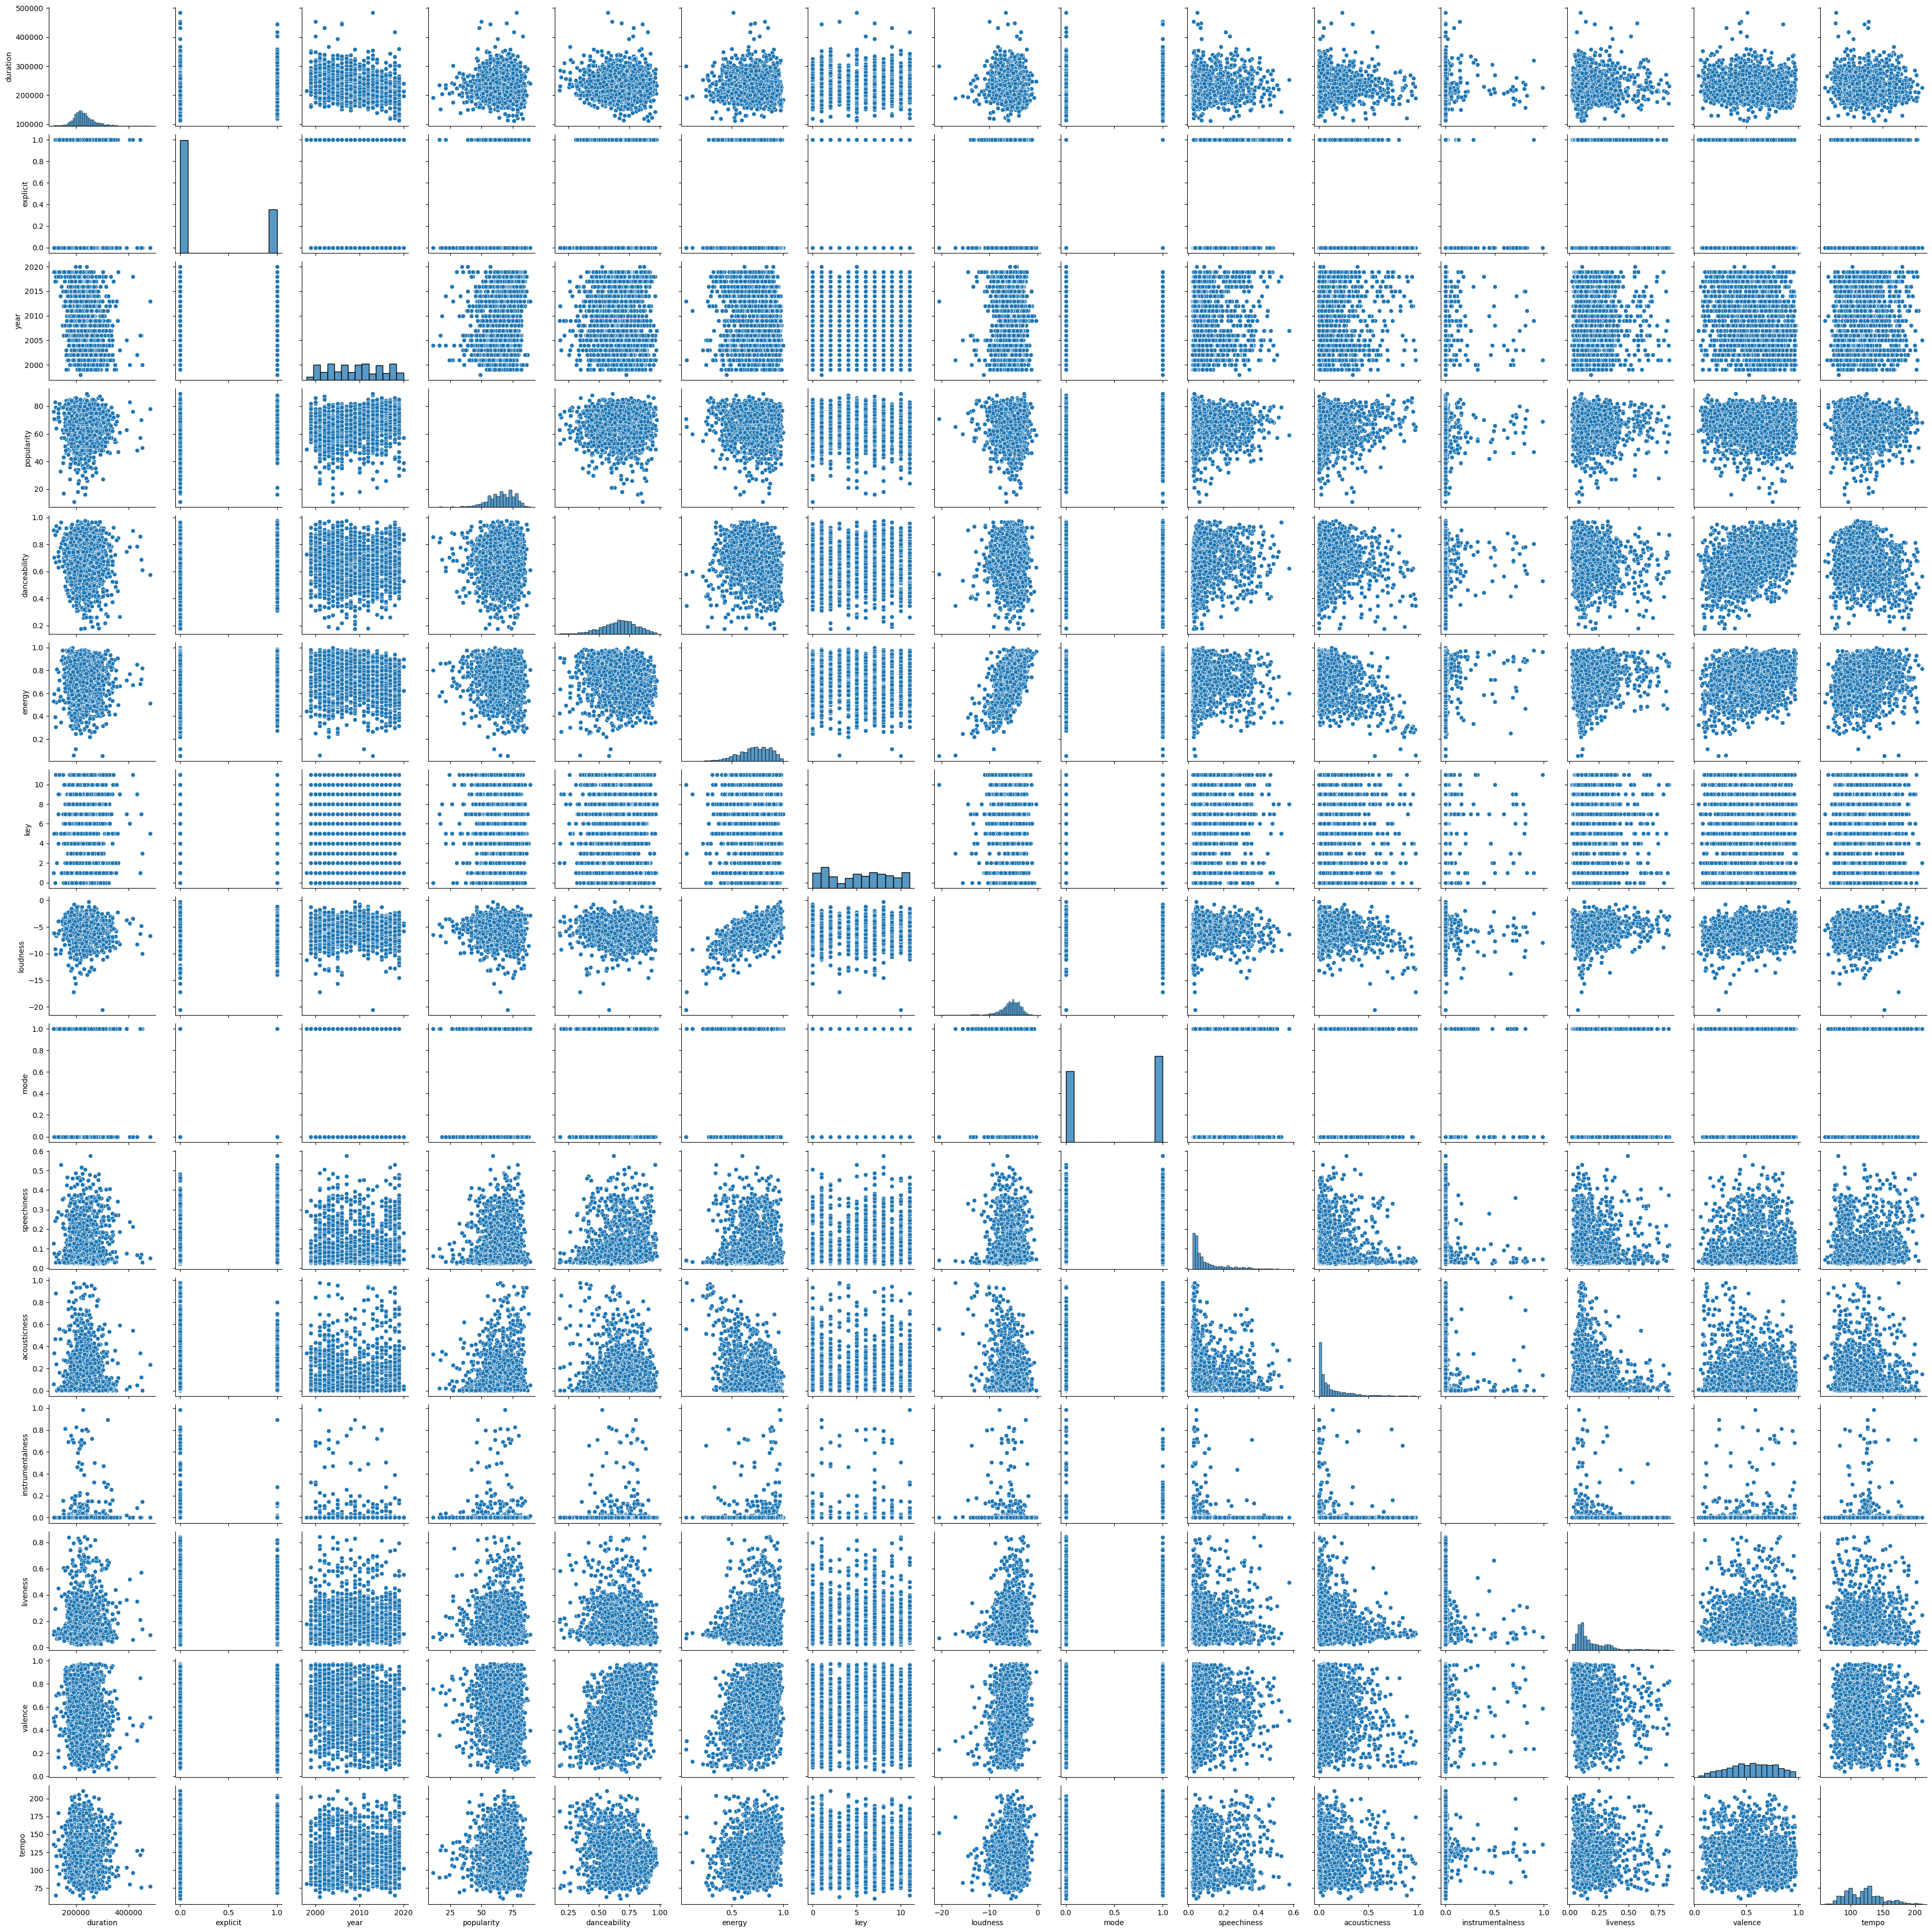

In [13]:
columns = ['duration', 'explicit', 'year', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
          'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
sns.pairplot(df[columns])
plt.show()

In [14]:
fig=px.treemap(df, path=[px.Constant('Singer'), 'artist', 'genre', 'song'], values='popularity')
fig.update_traces(root_color='seagreen', textfont_color='white')
fig.update_layout(title_x=0.5, title={'text':'<b>Tree Map of Singers</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [15]:
# song_count

In [16]:
fig = px.bar(df.groupby('artist', as_index=False).count().sort_values(by='song', ascending=False).head(50), 
       x='artist', y='song', labels={'song':'Total Songs', 'artist':'Artist'}, color_discrete_sequence=['limegreen'], 
       text='song', template='plotly_white')
fig.update_layout(title_x=0.5, title={'text':'<b>Number of Songs Recorded by Each Singer</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="grey")
fig.show()

In [17]:
fig = px.bar(df.groupby('artist', as_index=False).sum().sort_values(by='popularity', ascending=False).head(15), 
             x='artist', y='popularity', labels={'popularity':'Popularity', 'artist':'Artist'}, 
             color_discrete_sequence=['limegreen'], text='popularity', template='plotly_white')
fig.update_layout(title_x=0.5, title={'text':'<b>Top 15 Singers</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="grey")
fig.show()

In [18]:
genre_counts = df['genre'].value_counts()
genre_df = pd.DataFrame({'Genre': genre_counts.index, 'Count': genre_counts.values})
genre_df

Genre  Count
0           hip hop    491
1               R&B    414
2               pop    410
3  Dance/Electronic    221
4              rock    158
5             metal     47
6             latin     39
7     Folk/Acoustic     23
8           country     17

In [19]:
fig = px.pie(genre_df, names='Genre', values='Count', title='Distribution of Music Genres')
fig.show()

In [56]:
fig = px.box(df, x='genre', y='popularity', color='genre', template='plotly_white', 
             labels={'genre':'Genre', 'popularity':'Popularity'})
fig.update_layout(title_x=0.5, title={'text':'<b>Popularity based on genre content</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="grey")
fig.show()

In [20]:
fig=px.pie(df.groupby('explicit', as_index=False).count().sort_values(by='song', ascending=False), names='explicit', 
           values='song', labels={'song':'Total songs', 'explicit':'Explicit'}, hole=.4, 
           color_discrete_sequence=['magenta', 'limegreen'])
fig.update_layout(title_x=0.5, title={'text':'<b>Songs having explicit content</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="grey")
fig.show()

In [21]:
fig = px.box(df, x='explicit', y='popularity', color='explicit', template='plotly_white', 
             color_discrete_sequence=['magenta', 'limegreen'], labels={'explicit':'Explicit', 'popularity':'Popularity'})
fig.update_layout(title_x=0.5, title={'text':'<b>Popularity based on explicit content</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="grey")
fig.show()

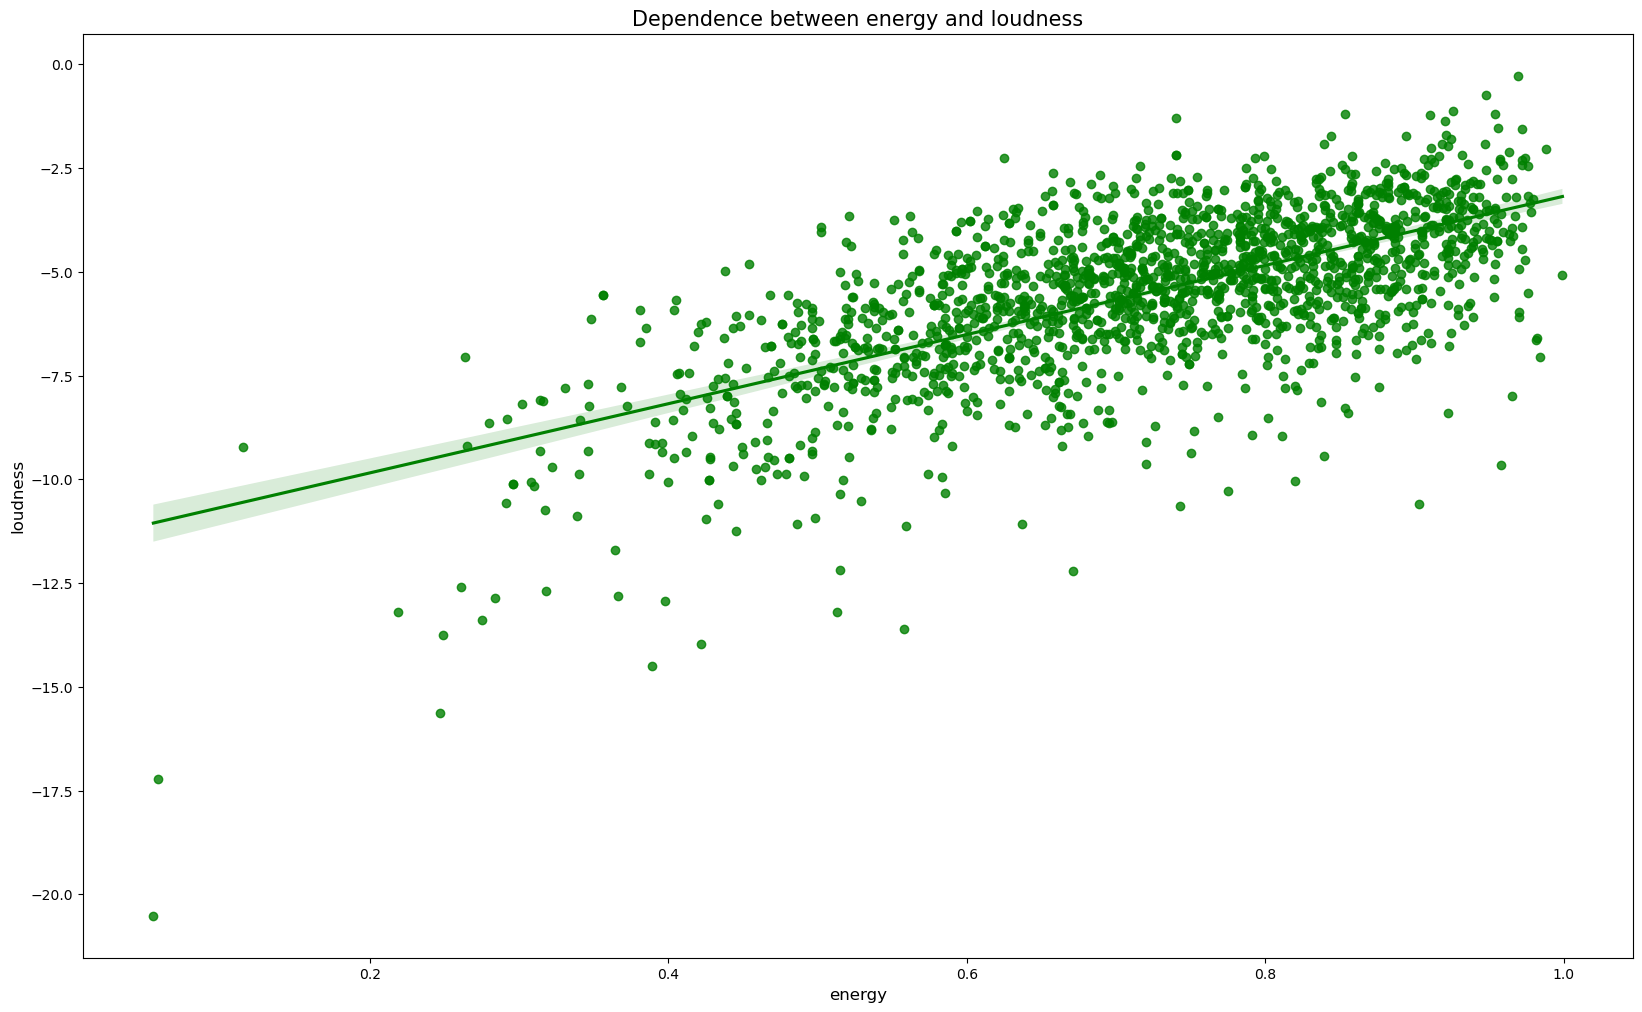

In [22]:
plt.figure(figsize=(20,12))
sns.regplot(data=df, x='energy', y='loudness', color='green')
plt.ylabel('loudness', fontsize=12)
plt.xlabel("energy", fontsize=12)
plt.title('Dependence between energy and loudness', fontsize=15)
plt.show()

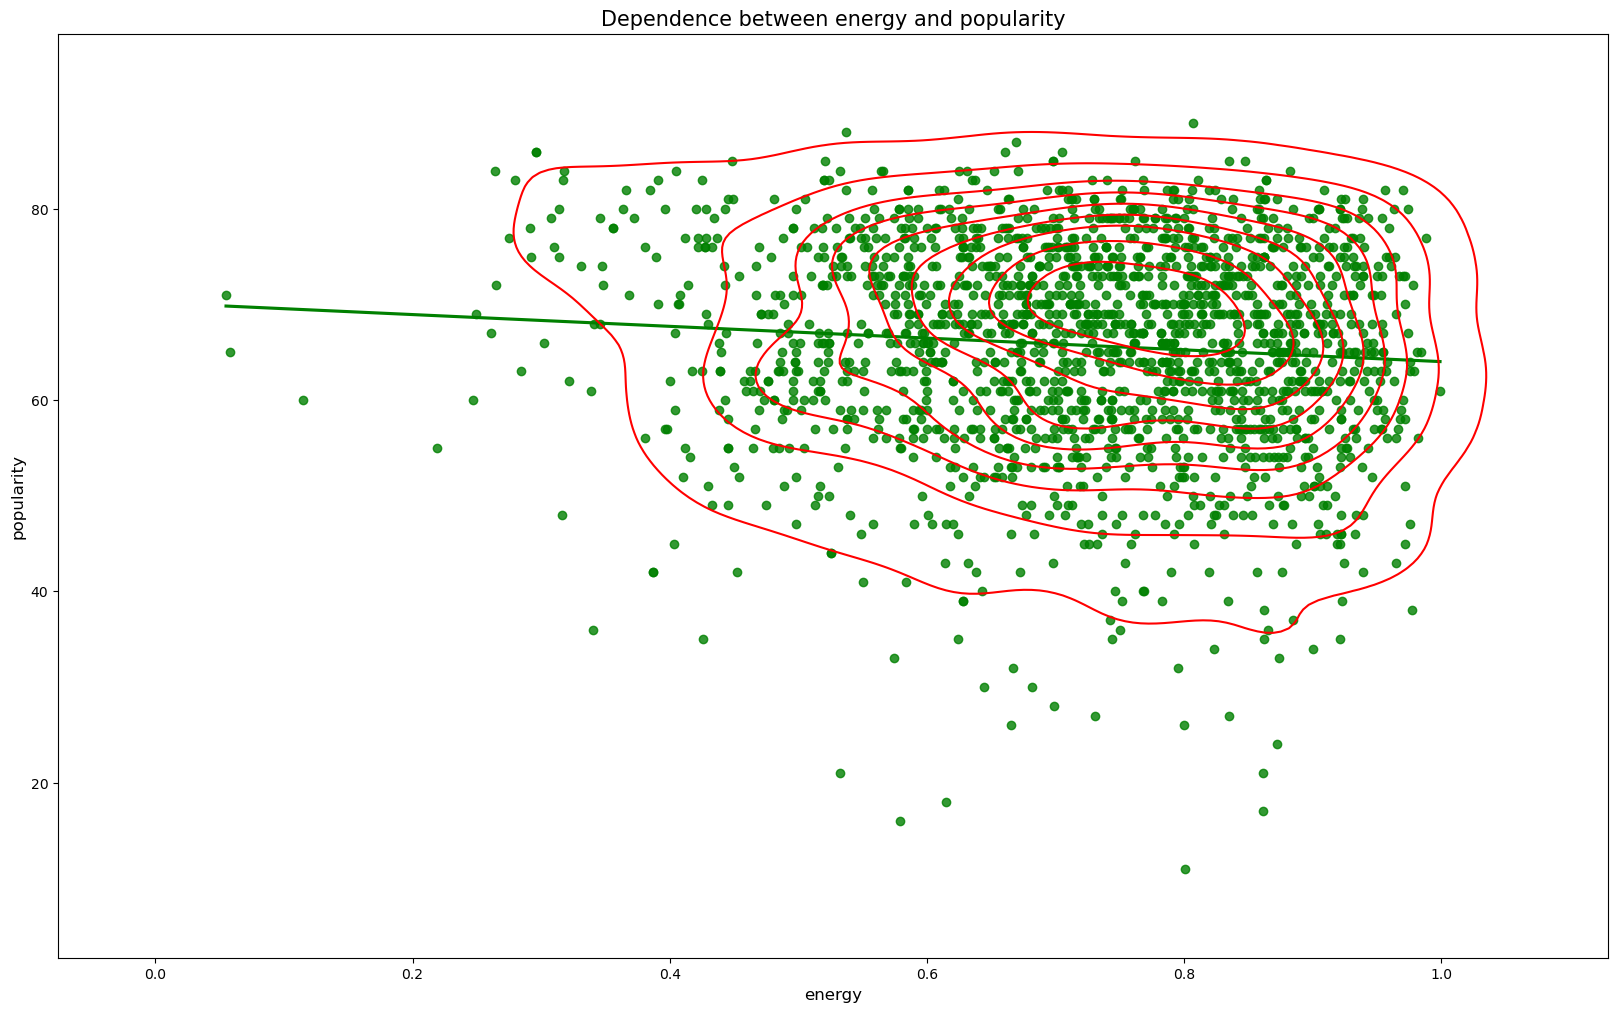

In [23]:
plt.figure(figsize=(20,12))
sns.regplot(data=df, x='energy', y='popularity', ci=None, color='green')
sns.kdeplot(x=df.energy, y=df.popularity, color='red')
plt.ylabel('popularity', fontsize=12)
plt.xlabel("energy", fontsize=12)
plt.title('Dependence between energy and popularity', fontsize=15)
plt.show()

<Figure size 2000x1200 with 0 Axes>

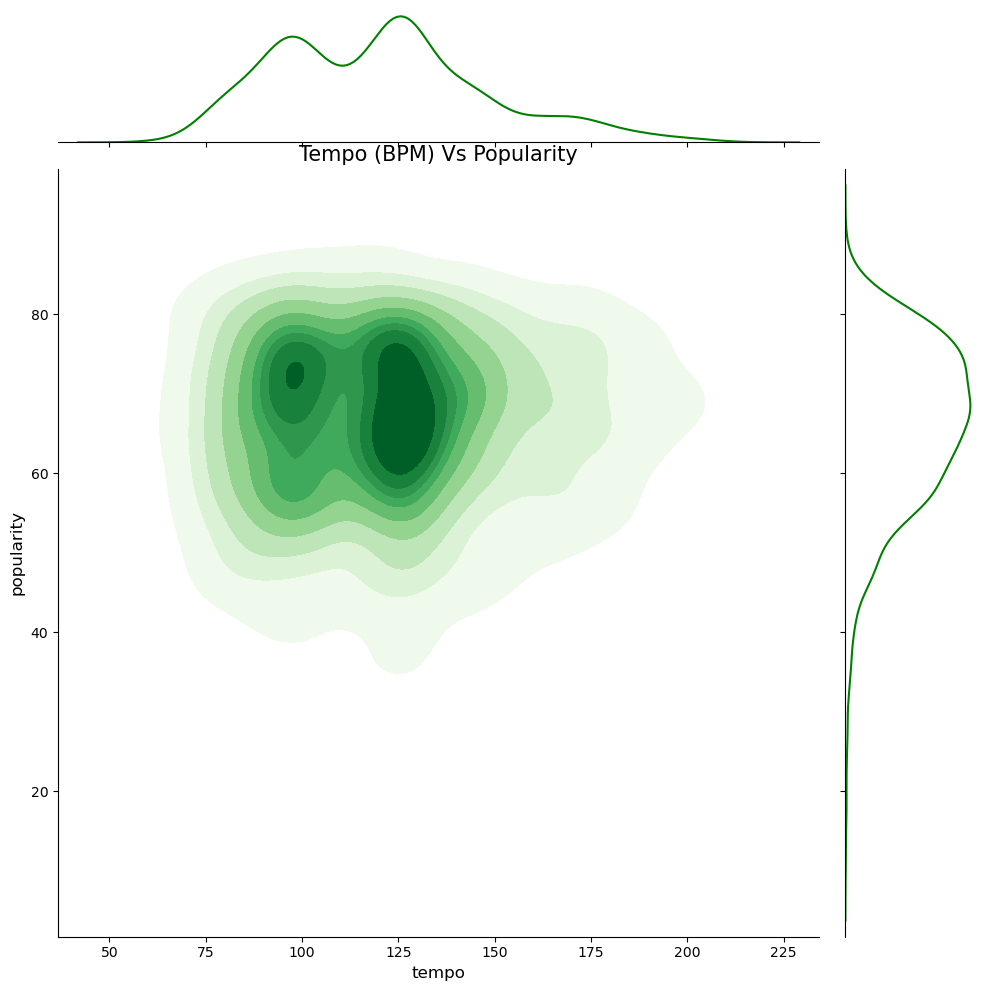

In [24]:
plt.figure(figsize=(20,12))
fig = sns.jointplot(data=df, x='tempo', y='popularity', kind="kde", color='green', shade=True, cmap="Greens", height=10)
plt.ylabel('popularity', fontsize=12)
plt.xlabel("tempo", fontsize=12)
plt.title("Tempo (BPM) Vs Popularity", fontsize=15)
plt.show()

In [25]:
# fig=make_subplots(rows=3,cols=3,subplot_titles=('<i>popularity', '<i>danceability', '<i>energy', 
#                                                 '<i>loudness', '<i>speechiness', '<i>acousticness', 
#                                                 '<i>liveness', '<i>valence', '<i>tempo'))
# fig.add_trace(go.Histogram(x=df['popularity'], name='popularity'), row=1, col=1)
# fig.add_trace(go.Histogram(x=df['danceability'], name='danceability'), row=1, col=2)
# fig.add_trace(go.Histogram(x=df['energy'], name='energy'), row=1, col=3)
# fig.add_trace(go.Histogram(x=df['loudness'], name='loudness'), row=2, col=1)
# fig.add_trace(go.Histogram(x=df['speechiness'], name='speechiness'), row=2, col=2)
# fig.add_trace(go.Histogram(x=df['acousticness'], name='acousticness'), row=2, col=3)
# fig.add_trace(go.Histogram(x=df['liveness'], name='liveness'), row=3, col=1)
# fig.add_trace(go.Histogram(x=df['valence'], name='valence'), row=3, col=2)
# fig.add_trace(go.Histogram(x=df['tempo'], name='tempo'), row=3,col=3)
# fig.update_layout(height=900, width=900, title_text='<b>Feature Distribution')
# fig.update_layout(template='plotly_dark', title_x=0.5)

In [26]:
features = ['duration', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']
target = ['popularity']

In [31]:
# df = pd.DataFrame(dict(
#     r=[1, 5, 2, 2, 3],
#     theta=['processing cost','mechanical properties','chemical stability',
#            'thermal stability', 'device integration']))
fig = px.line_polar(df, r=df[features].mean(), theta=features, line_close=True)
fig.update_traces(fill='toself')
fig.show()

In [32]:
X = df[features]
y = df[target]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 233.08516483516485
Mean Absolute Error: 11.755494505494505


In [35]:
feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_df

Feature  Importance
0      duration    0.108552
1  danceability    0.091814
2        energy    0.138488
3      loudness    0.123546
4   speechiness    0.099937
5  acousticness    0.107658
6      liveness    0.140045
7       valence    0.089510
8         tempo    0.100451

In [36]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 108.16740943309895
Mean Absolute Error: 8.463501911949544


In [37]:
selector = SelectKBest(k='all')

selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, max_depth=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

import pickle

# Assuming your model is named 'model'
with open('random_forest_model.h5', 'wb') as file:
    pickle.dump(model, file)

Mean Squared Error: 105.85670101231125
Mean Absolute Error: 8.294705586080587


In [41]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.argmax()})
comparison

ValueError: If using all scalar values, you must pass an index

In [45]:
selector = SelectFromModel(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                 max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
                                                 min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                                 n_estimators=100, n_jobs=-1, oob_score=False, random_state=0, verbose=0, 
                                                 warm_start=False), 
                          max_features=None, norm_order=1, prefit=False, threshold=0.15)

selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, max_depth=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

ValueError: Found array with 0 feature(s) (shape=(1456, 0)) while a minimum of 1 is required by RandomForestRegressor.

In [46]:
model = BaggingRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Bagging Regressor with Decision Tree base estimator:")
# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)
# print("R-squared:", r2)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -8.336 (0.455)


In [47]:
# Create an XGBoost Regressor model
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred)

print("XGBoost Regressor:")
print("Mean Squared Error:", mse_xgb)
print("Mean Absolute Error:", mae_xgb)

XGBoost Regressor:
Mean Squared Error: 112.3411330444892
Mean Absolute Error: 8.55779854281918


In [48]:
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
gb_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred_gb = gb_regressor.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print("\nGradient Boosting Regressor:")
print("Mean Squared Error:", mse_gb)
print("Mean Absolute Error:", mae_gb)


Gradient Boosting Regressor:
Mean Squared Error: 108.204178459528
Mean Absolute Error: 8.432682259905318


In [49]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [50]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.2439679 , 0.16650835])

In [51]:
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 121.70097775513337
Mean Absolute Error: 8.978176599020486


In [ ]:
# alt_df = pd.read_csv('spotify_tracks.csv', index_col=0)
# alt_df

In [ ]:
# alt_df.sort_values('popularity', ascending=False)

In [ ]:
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

In [52]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_train)
y_pred1 = mlp.predict(X_test)
m1 = mean_absolute_error(y_train, y_pred)
m2 = mean_absolute_error(y_test, y_pred1)
print("MAE of MLP Regressor on training set: {:.3f}".format(m1))
print("MAE of MLP Regressor on test set: {:.3f}".format(m2))

MAE of MLP Regressor on training set: 9.290
MAE of MLP Regressor on test set: 9.570


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# model = Sequential()
# model.add(Dense(12, input_dim=7, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # Compile model
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# # Fit the model
# model.fit(X, y, epochs=150, batch_size=10, verbose=0)
# # evaluate the model
# scores = model.evaluate(X, y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
%%writefile app.py

import streamlit as st
import streamlit.components.v1 as components

import pickle

with open('random_forest_model.h5', 'rb') as file:
    model = pickle.load(file)

def predict_popu(duration_ms, danceability, energy, loudness, speechiness, acousticness, valence):
    """
    this method is for prediction process 
    takes all the Audio characteristics thtat we used for modelling and returns the prediction 
    """
    prediction = model.predict([[duration_ms, danceability, energy, loudness, speechiness, acousticness, valence]])
    return prediction[0]

def main():
    st.title("Spotify Songs")
     
    html_temp2 = """
        <div style="background-color:royalblue;padding:10px;border-radius:10px">
        <h2 style="color:white;text-align:center;">Spotify Songs</h2>
        <h1 style="color:white;text-align:center;">Popularity prediction</h1>
        </div>
        """
    # a simple html code for heading which is in blue color and we can even use "st.write()" also ut for back ground color i used this HTML ..... 
    #  to render this we use ...
    components.html(html_temp2)
    # components.html() will render the render the 

    st.image("https://cdn2.downdetector.com/static/uploads/logo/Spotify_Logo_RGB_Green.png", width=700, use_column_width=False)

    # this is to insert the image the in the wed app simple <imag/> tag in HTML
    
    #now lets get the test input from the user by wed app 
    # for this we can use "st.text_input()" which allows use to get the input from the user 
    
    duration_ms = st.number_input("duration_ms", min_value=0, max_value=99999999, value=200000, step=1000)
    danceability = st.number_input("danceability", min_value=0.0, max_value=1.0, value=0.5, step=0.01)
    energy = st.number_input("energy", min_value=0.0, max_value=1.0, value=0.5, step=0.01)
    loudness = st.number_input("loudness", min_value=-60.0, max_value=60.0, value=-10.0, step=0.1)
    speechiness = st.number_input("speechiness", min_value=0.0, max_value=1.0, value=0.5, step=0.01)
    acousticness = st.number_input("acousticness", min_value=0.0, max_value=1.0, value=0.5, step=0.01)
    valence = st.number_input("valence", min_value=0.0, max_value=1.0, value=0.5, step=0.01)
    
    result=""
    # done we got all the user inputs to predict and we need a button like a predict button we do that by "st.button()"
    # after hitting the button the prediction process will go on and then we print the success message by "st.success()"
    if st.button("Predict"):
        result = predict_popu(duration_ms, danceability, energy, loudness, speechiness, acousticness, valence)
        st.success('The Popularity of the song is {}'.format(result))

if __name__=='__main__':
    main()